# Wavelength Calibration

In all of the spectra that we have extracted the flux was retrieved as a function of pixel, and not wavelength. That is because it is not known which pixel corresponds to which wavelength. To compute this so-called wavelength solution a known source is used to illuminated to the CCD and then identified the known lines to find the realtion of each pixels to the wavelength. In HARPS a Thorium-Argon lamp is used for such calibration. The idea is, as already mentioned, to illuminate the CCD with this lamp and identify the known lines in the pixel space and then use the wavelength of this known lines to relate the pixel space to the wavelength space.

The calibration files in the present data is marked with `WAVE,WAVE,THAR2` keyword in the header of the fits. The procedure to extract spectrum is exactly same as the science spectra extraction we performed earlier. Hence we do not describe the detail here, the interested reader can refer another notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from astropy.io import fits
from scipy.optimize import curve_fit as cft
from scipy.optimize import minimize as mz
import os
import utils as utl

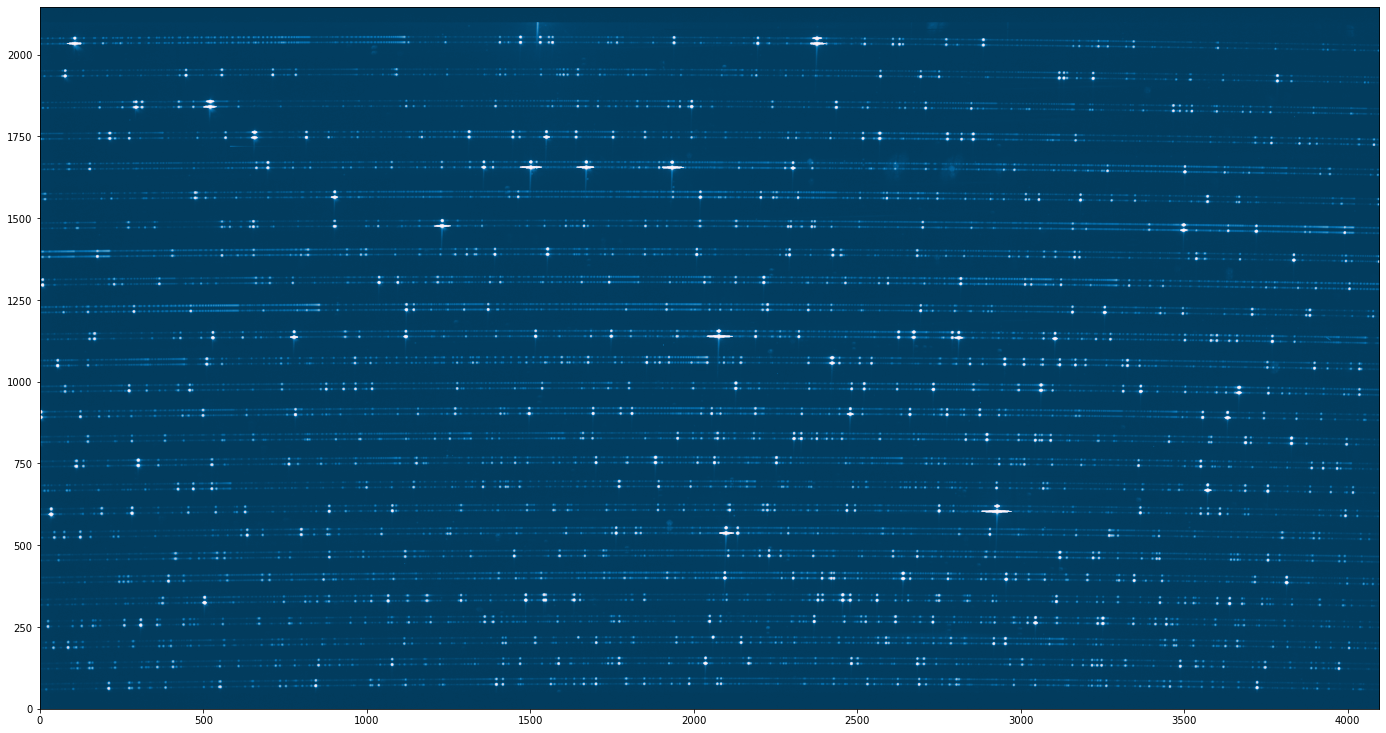

In [2]:
p1 = os.getcwd() + '/Spectro-Module/raw/'
list_all = os.listdir(p1)
list_wave = []

for i in range(len(list_all)):
    hdul = fits.open(p1 + list_all[i])
    h11 = hdul[0].header
    if h11['HIERARCH ESO DPR TYPE'] == 'WAVE,WAVE,THAR2':
        list_wave.append(list_all[i])

list_wave.sort(key=utl.natural_keys)

fla1 = fits.open(p1 + list_wave[0])
fla2 = fla1[2].data
fla3 = np.transpose(fla2)
plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(fla3, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')

## Bias Subtraction

In [3]:
bias_data = fla3[2098:]
bias_data2 = np.ndarray.flatten(bias_data)
bias_0 = np.mean(bias_data2)
std_0 = np.std(bias_data2)*1.42

# Subtracting the bias
fla4 = fla3 - bias_0
wave_0 = fla4*1.42

## Order identification

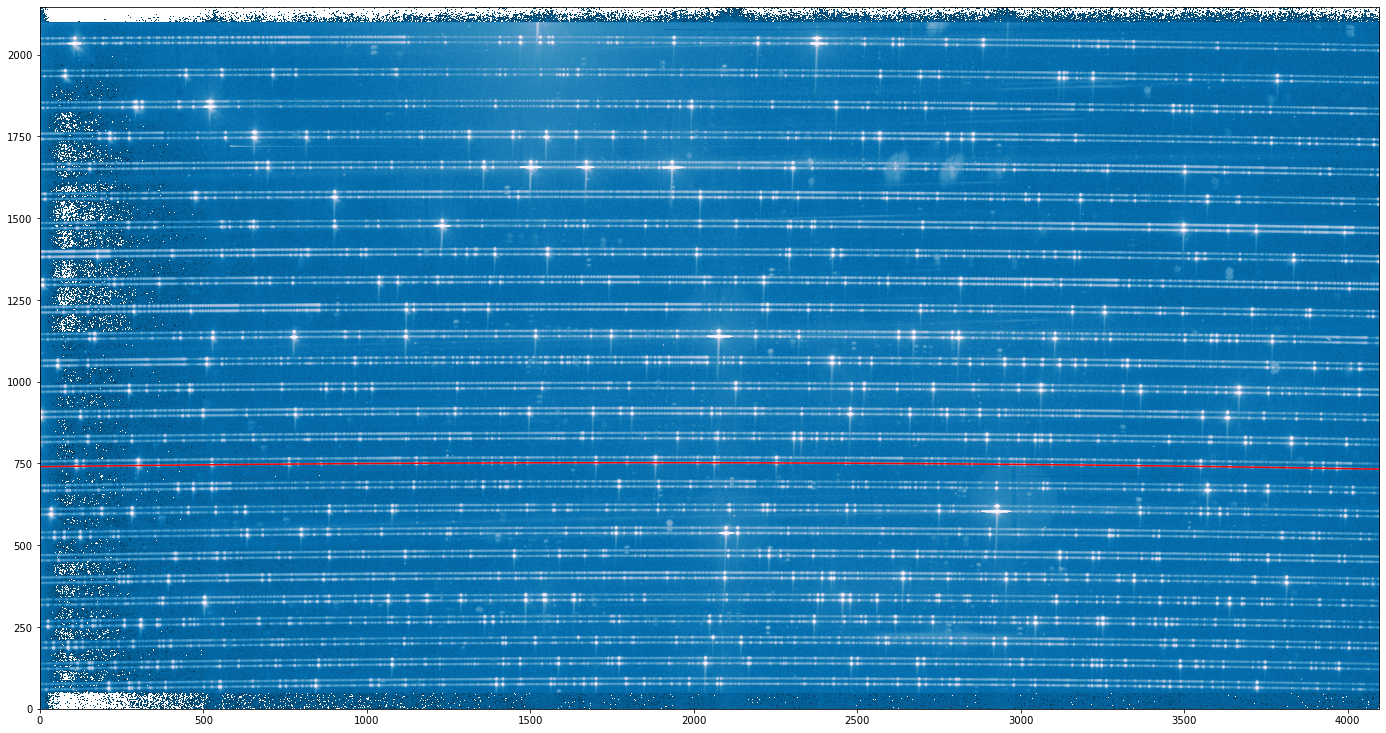

In [4]:
popt1 = np.array([1.49453189e+01, 1.33410596e-02, -3.52806113e-06, -4.42031001e-11])
xdata = np.arange(len(wave_0[0]))
ydata = utl.cubic_104(xdata, *popt1)

plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(wave_0, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')
plt.plot(xdata, ydata, c='red')

## Spectral Extraction

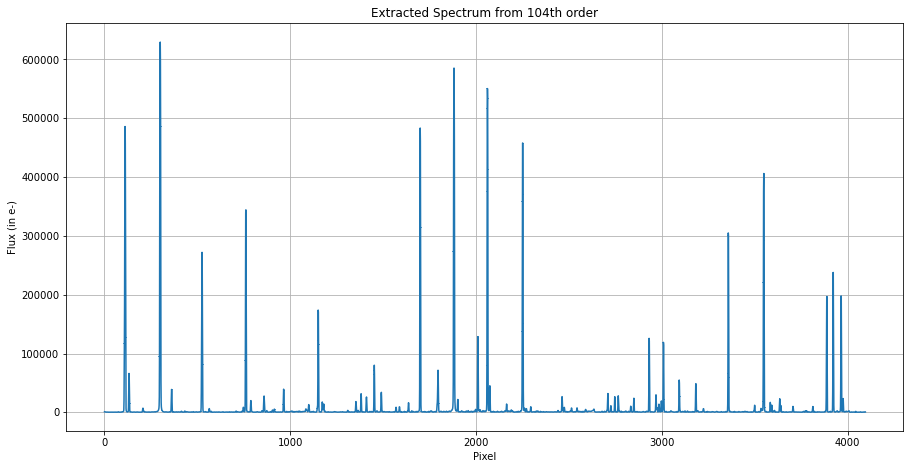

In [5]:
flux_wave = np.array([])
flux_wave_err = np.array([])

for i in range(len(ydata)):
    data = wave_0[int(ydata[i])-7:int(ydata[i]+7), i]
    flx = np.sum(data)
    flux_wave = np.hstack((flux_wave, flx))
    photon_noise = np.sqrt(flx)
    tot_noise = np.sqrt(photon_noise**2 + std_0**2)
    flux_wave_err = np.hstack((flux_wave_err, tot_noise))

plt.figure(figsize=(15,7.5))
plt.errorbar(xdata, flux_wave, yerr=flux_wave_err)
plt.xlabel('Pixel')
plt.ylabel('Flux (in e-)')
plt.title('Extracted Spectrum from 104th order')
plt.grid()

## Correction for flats

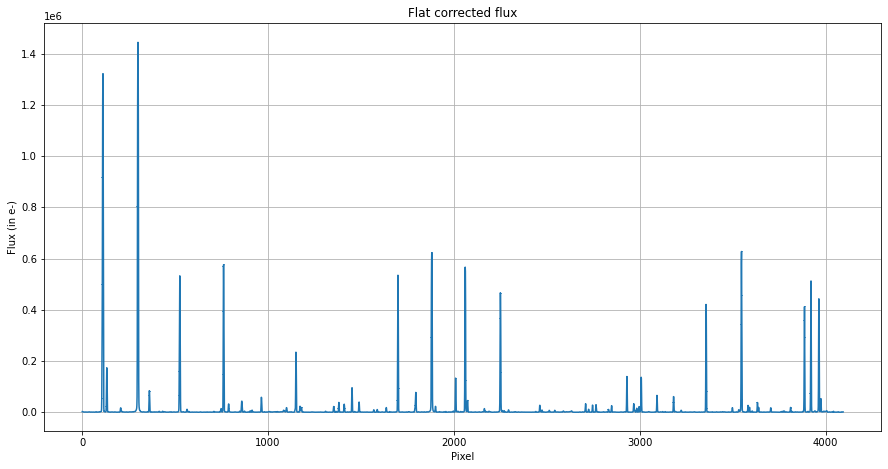

In [6]:
x1, flat, flat_err = np.loadtxt(os.getcwd() + '/Results/flat_normal.dat', usecols=(0,1,2), unpack=True)

flux_wave_fl = flux_wave/flat
flux_wave_fl_err = np.abs(flux_wave_fl)*np.sqrt((flux_wave_err/flux_wave)**2 + (flat_err/flat)**2)

plt.figure(figsize=(15,7.5))
plt.errorbar(xdata, flux_wave_fl, yerr=flux_wave_fl_err)
plt.xlabel('Pixel')
plt.ylabel('Flux (in e-)')
plt.title('Flat corrected flux')
plt.grid()

## Repeating the procedure for all of the Calibration files

In [7]:
for j in range(len(list_wave)):
    # Reading fits
    fla1_n = fits.open(p1 + list_wave[j])
    fla2_n = fla1_n[2].data
    fla3_n = np.transpose(fla2_n)
    # Bias Subtraction
    bias_data = fla3_n[2098:]
    bias_data2 = np.ndarray.flatten(bias_data)
    bias_0 = np.mean(bias_data2)
    std_0 = np.std(bias_data2)*1.42

    # Subtracting the bias
    fla4_n = fla3_n - bias_0
    wave_n = fla4_n*1.42

    # Tracing the order
    xdata_n = np.arange(len(wave_n[0]))
    ydata_n = utl.cubic_104(xdata_n, *popt1)

    # Extracting the flux
    flux_wave_n = np.array([])
    flux_wave_err_n = np.array([])

    for i in range(len(ydata_n)):
        data = wave_n[int(ydata_n[i])-7:int(ydata_n[i]+7), i]
        flx = np.sum(data)
        flux_wave_n = np.hstack((flux_wave_n, flx))
        photon_noise = np.sqrt(flx)
        tot_noise = np.sqrt(photon_noise**2 + std_0**2)
        flux_wave_err_n = np.hstack((flux_wave_err_n, tot_noise))

    # Correcting for flat
    flux_wave_fl_n = flux_wave_n/flat
    flux_wave_fl_err_n = np.abs(flux_wave_fl_n)*np.sqrt((flux_wave_err_n/flux_wave_n)**2 + (flat_err/flat)**2)

    f11 = open(os.getcwd() + '/Results/' + list_wave[j] + '_wave.dat', 'w')
    for k in range(len(xdata_n)):
        f11.write(str(xdata_n[k]) + '\t' + str(flux_wave_fl_n[k]) + '\t' + str(flux_wave_fl_err_n[k]) + '\n')

    f11.close()